In [371]:
import json
import numpy as np
import pandas as pd
from Index import Index 
from collections import Counter
from sklearn.manifold import TSNE 
from matplotlib import pyplot as plt 
from sklearn.decomposition import PCA
from sklearn.cluster import DBSCAN as skDB
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from utils import DBscan, NaiveBayes, grid_search, plot_graphs

import warnings
warnings.filterwarnings("ignore") 

In [3]:
index = Index(('DS\\index.json', 'DS\\inverted.json', 'DS\\queries.json', 'DS\\ground_truth.csv', 'DS\\raw_queries.json', 'DS\\raw_docs.json'), preprocessed=True)

In [4]:
data = np.array(list([list(i.keys()) for i in index.index.values()]), dtype=object) 

# Raw data

In [12]:
db = DBscan(eps=0.2, min_samples=10, similarity='jaccard') 
clusters = db.cluster(data, stop=True) 
np.save('Distances//Distances_Jac.npy', db.dist_matrix) 
dist_matrix = np.load('Distances//Distances_Jac.npy')
s = not_inf = ~np.isinf(dist_matrix) 
np.min(dist_matrix), np.max(dist_matrix[s]) 

Calculating distance matrix...


100%|██████████| 1460/1460 [00:11<00:00, 129.86it/s]


(0.0, 1.0)

In [13]:
db = DBscan(eps=0.2, min_samples=10, similarity='sim') 
clusters = db.cluster(data, stop=True)
np.save('Distances//Distances_Sim.npy', db.dist_matrix) 
dist_matrix = np.load('Distances//Distances_Sim.npy')
s = not_inf = ~np.isinf(dist_matrix) 
np.min(dist_matrix), np.max(dist_matrix[s]) 

Calculating distance matrix...


100%|██████████| 1460/1460 [00:07<00:00, 198.06it/s]


(0.0, 336.0)

# One-H ecoding

In [7]:
X = list([list(i.keys()) for i in index.index.values()])
flat = [i for j in X for i in j] 
features = np.unique(flat)
token_to_index_mapping = {t:i for t, i in zip(features, range(len(features)))}

In [8]:
def message_to_count_vector(i, doc):
    count_vector = np.zeros(len(features))
    for token in doc:
        if token in features:
            id = token_to_index_mapping[token]
            count_vector[id] = index.get_weight(str(i), token)
    return count_vector.tolist()

In [9]:
data_new = [np.array(message_to_count_vector(i, x)) for i, x in enumerate(X)]
data_new = np.array(data_new) 
data_new.shape 

(1460, 6946)

In [10]:
db = DBscan(eps=0.2, min_samples=10, similarity='hamming') 
clusters = db.cluster(data_new, stop=True)
np.save('Distances//Distances_Ham.npy', db.dist_matrix) 
dist_matrix = np.load('Distances//Distances_Ham.npy')
s = not_inf = ~np.isinf(dist_matrix) 
np.min(dist_matrix), np.max(dist_matrix[s]) 

Calculating distance matrix...


100%|██████████| 1460/1460 [00:39<00:00, 36.87it/s] 


(0.0, 0.05067664843075151)

In [11]:
db = DBscan(eps=0.2, min_samples=10, similarity='manhattan') 
clusters = db.cluster(data_new, stop=True)
np.save('Distances//Distances_Manh.npy', db.dist_matrix) 
dist_matrix = np.load('Distances//Distances_Manh.npy')
s = not_inf = ~np.isinf(dist_matrix) 
np.min(dist_matrix), np.max(dist_matrix[s]) 

Calculating distance matrix...


100%|██████████| 1460/1460 [02:17<00:00, 10.61it/s] 


(0.0, 157.55999999999997)

# Distribution

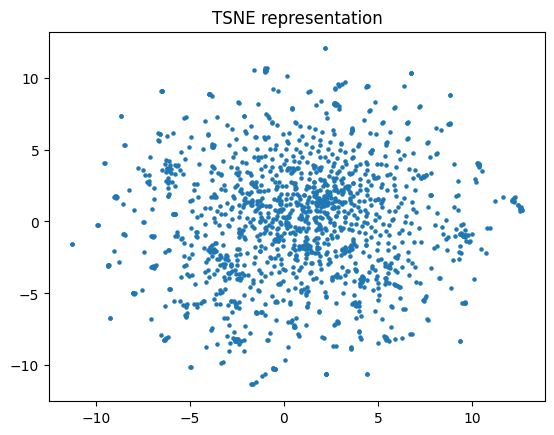

In [443]:
tsne = TSNE(random_state=42, n_components=2, verbose=0, perplexity=20, n_iter=3000, learning_rate='auto').fit_transform(data_new)
plt.scatter(tsne[:, 0], tsne[:, 1], s=5, cmap='Spectral') 
plt.title('TSNE representation')
plt.show() 

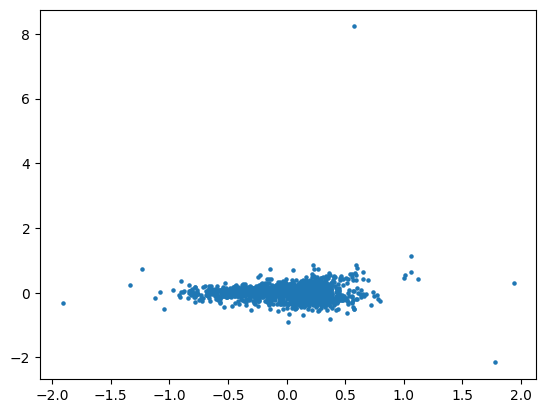

In [36]:
reduced_2d = PCA(2).fit_transform(data_new) 
plt.scatter(reduced_2d[:, 0], reduced_2d[:, 1], s=5, cmap='Spectral') 
plt.show() 

In [40]:
reduced = PCA().fit_transform(data_new) 
data_new.shape, reduced.shape 

((1460, 6946), (1460, 1460))

# Grid Search

## Raw Data

In [101]:
results_J = grid_search([i/500 for i in list(range(0, 20, 1))], range(10, 50, 2), data, np.load('Distances//Distances_Jac.npy'), 'jaccard')
results_S = grid_search(range(5, 150, 10), range(2, 10), data, np.load('Distances//Distances_Sim.npy'), 'sim')

100%|██████████| 21/21 [00:34<00:00,  1.66s/it]


In [ ]:
plot_graphs(results_J, 'Jaccard', 'Spectral') 
plot_graphs(results_S, 'Similarity', 'Spectral') 

## One-H Encoding

In [ ]:
results_H = grid_search([i/300 for i in range(1, 11)], range(2, 10), data_new, np.load('Distances//Distances_Ham.npy'), 'hamming')
results_M = grid_search(range(5, 26), range(2, 10), data_new, np.load('Distances//Distances_Manh.npy'), 'manhattan')

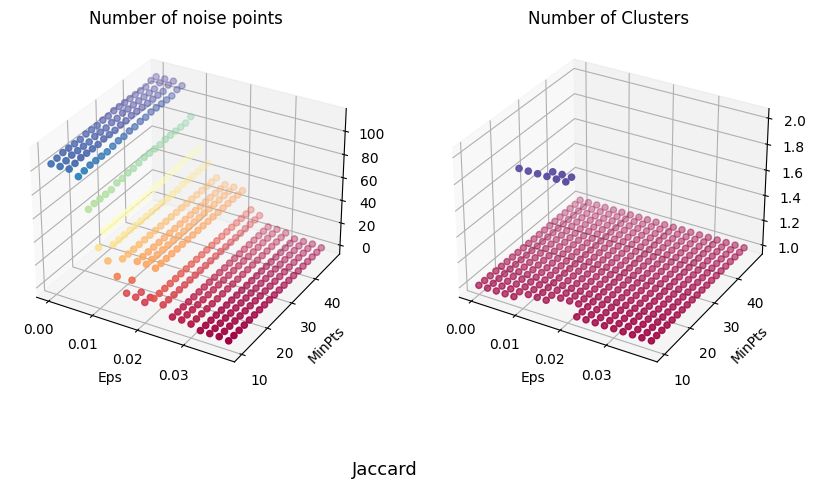

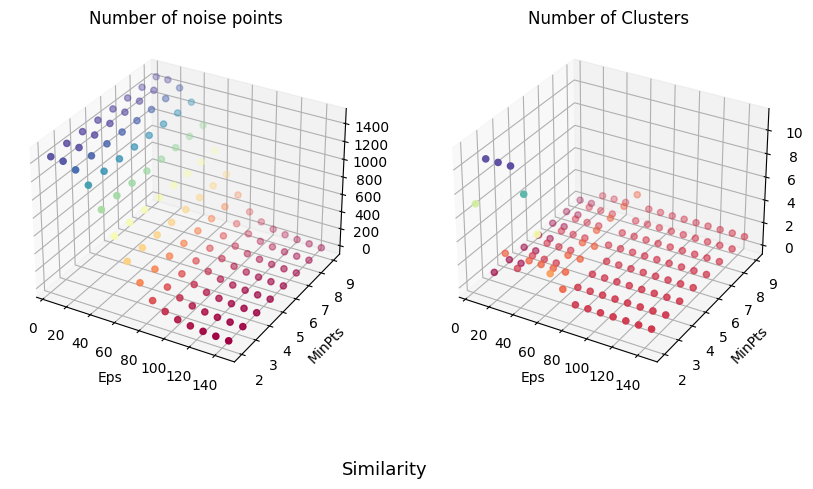

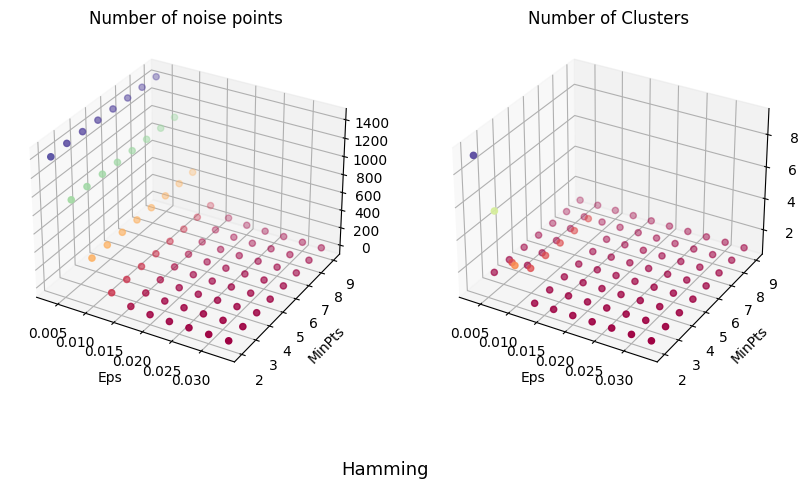

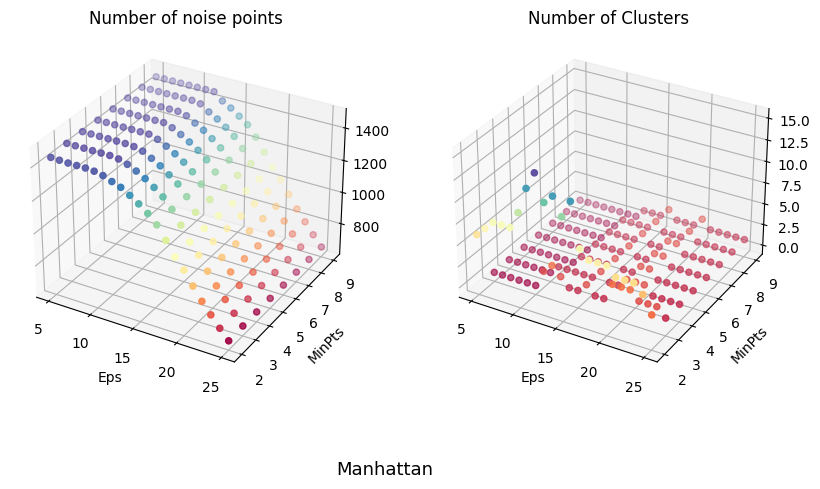

In [102]:
plot_graphs(results_H, 'Hamming', 'Spectral') 
plot_graphs(results_M, 'Manhattan', 'Spectral') 

## Reduced

### Euclidean

In [135]:
db = DBscan(eps=11, min_samples=2, similarity='euclidean') 
clusters = db.cluster(reduced)
np.save('Distances//Distances_Euc_Red.npy', db.dist_matrix)

Calculating distance matrix...


100%|██████████| 1460/1460 [00:48<00:00, 29.97it/s] 


In [136]:
dist_matrix = np.load('Distances//Distances_Euc_Red.npy')
s = not_inf = ~np.isinf(dist_matrix) 
np.min(dist_matrix), np.max(dist_matrix[s]) 

(7.650394065325363e-15, 16.187127601894048)

100%|██████████| 15/15 [01:30<00:00,  6.01s/it]


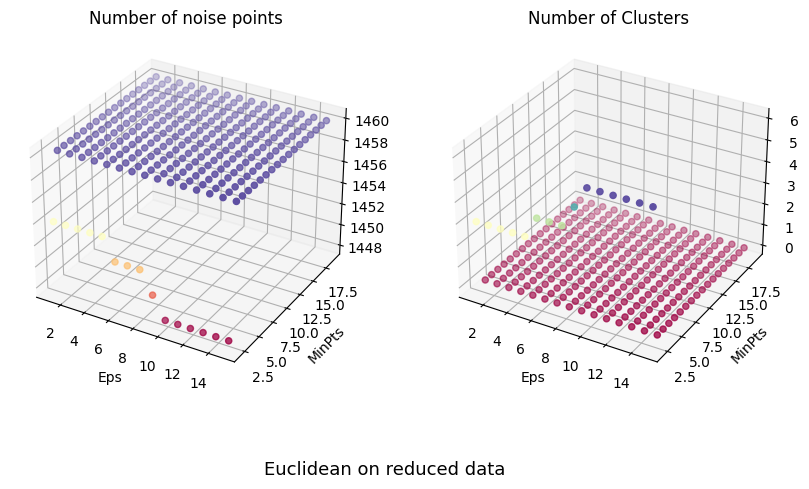

In [137]:
results_E_Red = grid_search(range(1, 16, 1), range(2, 20), reduced, np.load('Distances//Distances_Manh_Red.npy'), 'manhattan')
plot_graphs(results_E_Red, 'Euclidean on reduced data', 'Spectral') 

In [189]:
results_E_Red[results_E_Red['nb_clusters'] > 1]

,eps,min_samples,nb_clusters,noise
0,1,2,3,1454
18,2,2,3,1454
36,3,2,3,1454
54,4,2,3,1454
72,5,2,3,1454
90,6,2,4,1452
108,7,2,4,1452
126,8,2,4,1452
144,9,2,5,1450
162,10,2,6,1448


### Manhattan

In [132]:
db = DBscan(eps=105, min_samples=2, similarity='manhattan') 
clusters = db.cluster(reduced)
np.save('Distances//Distances_Manh_Red.npy', db.dist_matrix)

Calculating distance matrix...


100%|██████████| 1460/1460 [02:43<00:00,  8.94it/s] 


In [133]:
dist_matrix = np.load('Distances//Distances_Manh_Red.npy')
s = not_inf = ~np.isinf(dist_matrix) 
np.min(dist_matrix), np.max(dist_matrix[s]) 

(2.0665898574258564e-13, 157.38731171588276)

100%|██████████| 16/16 [01:56<00:00,  7.29s/it]


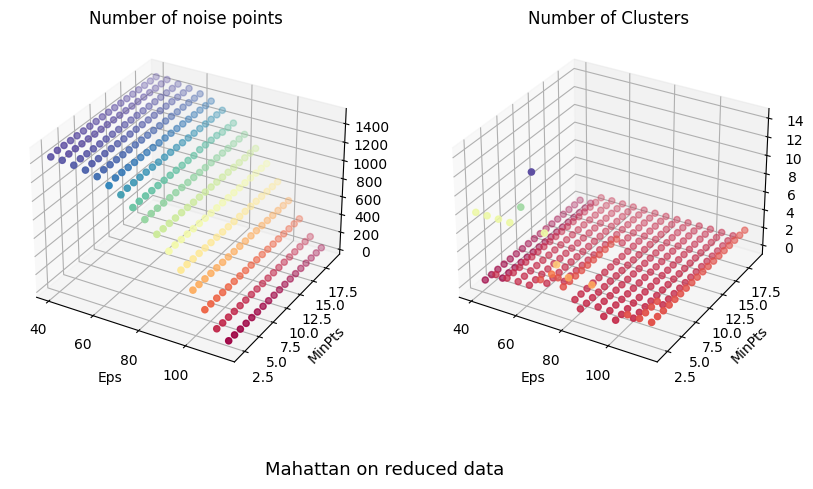

In [134]:
results_M_Red = grid_search(range(40, 120, 5), range(2, 20), reduced, np.load('Distances//Distances_Manh_Red.npy'), 'manhattan')
plot_graphs(results_M_Red, 'Mahattan on reduced data', 'Spectral') 

In [162]:
r = results_M_Red[(results_M_Red['nb_clusters'] > 1) & (results_M_Red['noise'] < 1000)]
eps_list = r['eps']
min_samples_list = r['min_samples']
r

,eps,min_samples,nb_clusters,noise
180,90,2,4,815
234,105,2,2,306
252,110,2,2,140
253,110,3,2,140
254,110,4,2,140
255,110,5,2,140
270,115,2,2,50
271,115,3,2,50
272,115,4,2,50
273,115,5,2,50


In [165]:
for eps, min_samples in zip(eps_list[:10], min_samples_list[:10]):
    db = DBscan(eps=eps, min_samples=min_samples, similarity='manhattan') 
    clusters = db.cluster(reduced, dist_matrix=np.load('Distances//Distances_Manh_Red.npy'))
    print(eps, min_samples, Counter(clusters))

90 2 Counter({-2: 815, 0: 639, 1: 2, 2: 2, 3: 2})
105 2 Counter({0: 940, -2: 306, 1: 214})
110 2 Counter({0: 1066, 1: 254, -2: 140})
110 3 Counter({0: 1066, 1: 254, -2: 140})
110 4 Counter({0: 1066, 1: 254, -2: 140})
110 5 Counter({0: 1066, 1: 254, -2: 140})
115 2 Counter({0: 1272, 1: 138, -2: 50})
115 3 Counter({0: 1272, 1: 138, -2: 50})
115 4 Counter({0: 1272, 1: 138, -2: 50})
115 5 Counter({0: 1272, 1: 138, -2: 50})


Distribution

In [302]:
db = DBscan(eps=105, min_samples=2, similarity='manhattan') 
clusters = db.cluster(reduced, dist_matrix=np.load('Distances//Distances_Manh_Red.npy'))
tsne = TSNE(random_state=42, n_components=2, verbose=0, perplexity=20, n_iter=3000, learning_rate='auto').fit_transform(reduced)

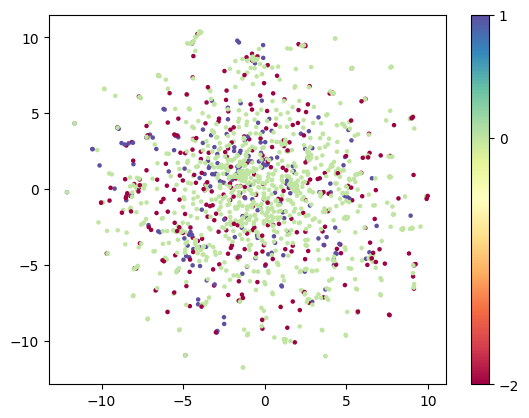

In [381]:
plt.scatter(tsne[:, 0], tsne[:, 1], s=5, c=clusters, cmap='Spectral', label=str(clusters)) 
cbar = plt.colorbar()
cbar.set_ticks(np.unique(clusters))
plt.show() 

# Bayes

In [422]:
index = Index(('DS\\index.json', 'DS\\inverted.json', 'DS\\queries.json', 'DS\\ground_truth.csv', 'DS\\raw_queries.json', 'DS\\raw_docs.json'), preprocessed=True)
y = index.ground_truth 
y['Relevent document'] = [clusters[doc-1] for doc in y['Relevent document']]
y

,Query,Relevent document
0,1,-2
1,1,-2
2,1,-2
3,1,-2
4,1,-2
...,...,...
3109,111,0
3110,111,0
3111,111,0
3112,111,0


In [423]:
y.drop(y[y['Relevent document'] == -2].index, inplace=True)
y 

,Query,Relevent document
5,1,1
6,1,1
8,1,1
9,1,1
10,1,1
...,...,...
3109,111,0
3110,111,0
3111,111,0
3112,111,0


In [424]:
grouped = y.groupby('Query')
def group_to_list(group):
    return np.array(group['Relevent document'])
ground_truth = np.array(grouped.apply(group_to_list))
ground_truth = [np.unique(row)[np.argmax(np.unique(row, return_counts=True)[1])] for row in ground_truth]

In [432]:
nb = NaiveBayes()
data = [index.queries[str(i)] for i in np.unique(y['Query'])]
labels = ground_truth
X_train, X_test, y_train, y_test = train_test_split(data, 
        ground_truth, test_size=0.2, shuffle=True, stratify=ground_truth)
nb.train(X_train, y_train)

pred = []
for query, gt in zip(X_test, y_test):
    prediction = nb.predict(query)
    pred.append(prediction)
    print(prediction, gt) 

0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 1
0 0
0 0
0 0


In [431]:
report = classification_report(y_test, pred)
print(report) 

              precision    recall  f1-score   support

           0       0.96      1.00      0.98        26
           1       0.00      0.00      0.00         1

    accuracy                           0.96        27
   macro avg       0.48      0.50      0.49        27
weighted avg       0.93      0.96      0.94        27



In [393]:
pred = [-1, 0, 0, -1, -1, -1, -1, -1, -1, -1, -1, 3, 2, -1, -1, -1, -1, 2, -1, -1, -1, -1, -1, 0, -1, -1, -1, -1, -1, -1, -1, -1, 2, 0, 0, -1, -1, -1, -1, -1, 3, -1, -1, 2, -1, -1, -1, -1, -1, 0, 3, -1, -1, -1, 0, -1, 3, 2, 0, 1, 3, -1, -1, 1, 1, -1, -1, -1, -1, 1, -1, 1, -1, -1, -1, -1, -1, 3, 3, 3, -1, -1, 3, 2, -1, 0, 0, -1, -1, -1, -1, 1, -1, -1, -1, -1, -1, -1, 2, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 0, -1, -1, -1, -1, -1, -1, -1, 1, -1, 1, -1, -1, -1, 0, -1, 0, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 1, 1, 1, -1, -1, -1, 1, -1, 2, 2, 3, -1, -1, 2, 3, -1, -1, -1, 2, -1, 1, -1, 1, 0, 1, -1, -1, 2, 1, -1, -1, -1, -1, 1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 1, -1, -1, -1, 3, 3, 0, 0, -1, -1, 2, -1, -1, 0, 3, -1, -1, -1, 1, -1, -1, -1, -1, -1, -1, -1, -1, 3, -1, 1, -1, -1, -1, -1, -1, 3, 2, 1, -1, 3, -1, -1, 1, -1, -1, -1, -1, -1, 0, 0, -1, -1, -1, -1, 2, 2, 0, 1, -1, -1, -1, -1, -1, -1, 2, -1, -1, -1, 1, 1, 1, -1, 0, -1, 2, -1, 1, -1, -1, -1, -1, 2, 3, -1, -1, -1, -1, 1, -1, -1, -1, 0, -1, -1, -1, -1, -1, 1, -1, -1, -1, 0, -1, -1, -1, -1, -1, -1, -1, 1, -1, -1, 3, -1, -1, -1, 3, -1, -1, -1, -1, -1, 3, -1, -1, 2, -1, 3, 3, -1, -1, -1, -1, 2, 3, 3, 2, -1, 1, -1, -1, -1, -1, -1, -1, -1, -1, 1, 2, -1, -1, -1, -1, -1, -1, -1, -1, 1, -1, -1, -1, 0, 0, 2, -1, -1, 2, -1, 1, -1, -1, -1, -1, -1, -1, -1, 1, 0, 1, -1, -1, -1, -1, -1, -1, -1, -1, 3, 0, -1, -1, 0, -1, -1, -1, 3, -1, -1, -1, 3, -1, -1, -1, -1, -1, -1, -1, 1, 2, -1, 2, 1, -1, -1, -1, -1, 0, 3, 0, -1, 3, -1, 3, -1, 1, -1, -1, 3, 0, 1, -1, 1, 2, 0, 1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 1, 0, -1, -1, -1, -1, -1, -1, 1, -1, -1, -1, -1, 1, -1, -1, -1, 1, -1, -1, 2, -1, -1, -1, -1, 1, -1, 1, -1, -1, 2, 1, -1, -1, -1, -1, -1, -1, -1, -1, 2, 0, 1, 0, -1, 0, 2, -1, 0, -1, -1, -1, -1, 2, -1, -1, -1, 1, -1, -1, -1, 1, 3, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 0, -1, 3, 1, -1, -1, -1, -1, 1, 1, -1, -1, -1, 3, 1, 2, -1, -1, -1, 3, -1, -1, -1, 2, 2, -1, -1, -1, -1, -1, -1, -1, -1, 1, 1, -1, -1, -1, -1, -1, -1, 0, 2, 2, -1, -1, -1, -1, -1, -1, -1, 1, -1, -1, 1, -1, -1, -1, -1, 1, 2, -1, 1, -1, -1, -1, 3, -1, -1, -1, -1, -1, 3, 2, -1, 3, -1, -1, -1, -1, -1, -1, -1, -1, -1, 3, -1, -1, 2, -1, -1, -1, -1, 3, -1, -1, -1, -1, -1, -1, 3, -1, -1, -1, -1, 1, 1, -1, -1, -1, -1, -1, -1, -1, 3, -1, -1, -1, -1, -1, 1, -1, -1, 2, -1, -1, 2, -1, -1, -1, -1, 1, 1, 1, -1, -1, -1, -1, -1, -1, 0, -1, -1, -1, -1, 2, -1, -1, 2, 1, -1, -1, -1, 3, -1, -1, 1, -1, -1, -1, -1, -1, -1, -1, 0, -1, 3, 1, -1, -1, -1, -1, -1, -1, -1, -1, 1, -1, -1, -1, -1, -1, -1, 0, -1, -1, 2, 2, -1, 1, -1, 1, -1, 3, -1, -1, -1, -1, -1, -1, 0, -1, 3, -1, -1, -1, 3, -1, -1, -1, -1, 0, 0, 1, -1, -1, 1, 3, -1, 0, -1, 3, -1, -1, 0, 3, -1, -1, -1, -1, 1, -1, -1, 0, 3, 0, 0, -1, -1, 0, -1, -1, -1, 3, -1, 0, 2, -1, -1, -1, -1, -1, 2, -1, -1, 0, -1, 0, 1, -1, 2, 1, 0, -1, -1, -1, -1, -1, 1, -1, -1, -1, -1, -1, -1, -1, 2, -1, -1, -1, 2, -1, -1, -1, -1, -1, 0, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 3, 2, -1, -1, -1, 3, 2, -1, -1, -1, 3, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 0, 2, 3, -1, -1, 2, -1, 1, -1, -1, -1, -1, 1, -1, 1, -1, 2, -1, 1, -1, -1, -1, 0, -1, 0, 1, 0, 3, 1, 3, 1, 2, -1, -1, 0, 0, -1, 1, 0, -1, -1, 1, 3, 3, 1, 0, 1, -1, -1, -1, 0, -1, 3, 1, 0, 3, 0, -1, -1, -1, -1, 2, 1, -1, -1, -1, -1, 2, -1, 0, -1, 1, -1, 1, -1, 1, -1, -1, -1, -1, -1, 2, -1, -1, -1, 1, -1, 0, 3, -1, 0, -1, 0, 0, 1, 1, 1, 0, 2, 2, -1, -1, 3, 1, -1, -1, 2, -1, -1, 1, 0, -1, -1, -1, -1, 1, 2, -1, -1, -1, -1, -1, -1, -1, 3, -1, -1, -1, 3, -1, -1, 2, -1, -1, -1, 1, 1, -1, 1, 1, 1, 2, 1, -1, 1, 1, 3, 1, -1, -1, -1, -1, -1, -1, 0, -1, -1, -1, -1, 1, -1, 0, 0, 1, -1, 3, -1, 0, 1, -1, 0, 1, 0, -1, -1, -1, -1, 3, -1, 0, 0, -1, -1, 2, 0, 2, -1, 1, -1, -1, -1, -1, 1, -1, 2, -1, -1, -1, 0, 0, -1, 0, -1, -1, 2, -1, 3, -1, 1, -1, -1, -1, 1, -1, -1, -1, 1, -1, 1, -1, -1, 1, 1, -1, 2, -1, 0, -1, -1, -1, -1, 1, 1, 0, -1, -1, -1, 3, 2, 2, -1, 1, -1, -1, 1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 0, -1, -1, -1, -1, -1, -1, -1, -1, 1, -1, -1, -1, -1, -1, -1, 3, -1, 0, -1, 1, -1, 3, -1, 0, -1, -1, 1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 3, -1, -1, -1, -1, 3, -1, -1, -1, -1, -1, -1, 2, -1, -1, -1, -1, -1, -1, -1, -1, -1, 2, -1, -1, 0, -1, -1, -1, -1, 0, -1, -1, -1, -1, -1, 3, 3, -1, 3, 0, -1, -1, -1, 3, 3, -1, -1, 3, -1, -1, -1, -1, 0, 2, -1, 2, 2, -1, 1, -1, 1, -1, 2, -1, -1, -1, 1, 0, 1, 3, -1, -1, 0, -1, -1, -1, 3, -1, 3, 1, -1, -1, 2, -1, -1, 1, -1, -1, -1, -1, -1, -1, -1, -1, 2, 3, -1, 2, -1, -1, -1, -1, 1, 3, -1, 1, -1, -1, -1, 3, 1, -1, -1, -1, -1, -1, 2, -1, -1, 0, -1, -1, -1, -1, 1, 3, -1, -1, 1, -1, 3, -1, -1, 0, 1, -1, 0, 1, 0, 0, -1, 2, 0, -1, -1, -1, -1, -1, -1, -1, 2, -1, 1, 3, -1, -1, -1, -1, -1, 2, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 3, 1, 2, 3, -1, -1, -1, -1, 1, -1, -1, 2, -1, -1, -1, 1, -1, -1, -1, -1, -1, -1, -1, -1, 3, 1, -1, 1, 1, 2, -1, -1, -1, 0, -1, 3, -1, 1, -1, -1, 2, -1, -1, -1, -1, -1, -1, -1, -1, -1, 1, -1, 1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 3, -1, -1, 1, -1, 3, 3, 1, -1, 1, -1, 0, -1, 3, -1, -1, -1, -1, -1, -1, 2, 0, -1, -1, -1, -1, -1, -1, 2, -1, 1, 0, 1, 1, -1, -1, -1, -1, -1, 1, 2, -1, -1, -1, -1, -1, -1, -1, 2, 0, 2, 1, 3, -1, -1, -1, -1, 1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 0, -1, 0, 0, 3, 0, -1, 1, -1, 0, -1, 2, -1, 2, -1, -1, 1, -1, -1, 2, 1, -1, -1, 2, -1, -1, -1, -1, 0]
len(pred)

1460

In [394]:
index = Index(('DS\\index.json', 'DS\\inverted.json', 'DS\\queries.json', 'DS\\ground_truth.csv', 'DS\\raw_queries.json', 'DS\\raw_docs.json'), preprocessed=True)
y = index.ground_truth 
y['Relevent document'] = [pred[doc-1] for doc in y['Relevent document']]
y

,Query,Relevent document
0,1,-1
1,1,0
2,1,-1
3,1,-1
4,1,-1
...,...,...
3109,111,-1
3110,111,-1
3111,111,-1
3112,111,-1


In [396]:
y.drop(y[y['Relevent document'] == -1].index, inplace=True)
y 

,Query,Relevent document
1,1,0
6,1,1
8,1,0
10,1,0
12,1,2
...,...,...
3077,109,0
3091,109,1
3095,109,1
3096,109,2


In [397]:
grouped = y.groupby('Query')
def group_to_list(group):
    return np.array(group['Relevent document'])
ground_truth = np.array(grouped.apply(group_to_list))
ground_truth = [np.unique(row)[np.argmax(np.unique(row, return_counts=True)[1])] for row in ground_truth]

In [442]:
nb = NaiveBayes()
data = [index.queries[str(i)] for i in np.unique(y['Query'])]
labels = ground_truth
X_train, X_test, y_train, y_test = train_test_split(data, ground_truth, test_size=0.2, shuffle=True, stratify=ground_truth)
nb.train(X_train, y_train) 

pred = []
for query, gt in zip(X_test, y_test):
    prediction = nb.predict(query)
    pred.append(prediction)
    print(prediction, gt) 

0 0
0 0
0 0
0 0
0 0
0 0
0 1
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0


In [419]:
report = classification_report(y_test, pred) 
print(report) 

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         4
           1       0.47      1.00      0.64         7
           2       0.00      0.00      0.00         1
           3       0.00      0.00      0.00         3

    accuracy                           0.47        15
   macro avg       0.12      0.25      0.16        15
weighted avg       0.22      0.47      0.30        15



In [ ]:
from xgboost import XGBClassifier
model = XGBClassifier()
model.fit(X_train, y_train)
pred = model.predict(X_test)
report = classification_report(y_test, pred) 
print(report) 